In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.style as style
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


%matplotlib inline
rcParams['figure.figsize'] = 10, 6
style.use('fivethirtyeight')

### Data Wrangling

In [2]:
#Bring in data & start cleaning up the time

df = pd.read_csv('buyer-spend.csv')
df['hour'] = df['hour'].astype('str')

myobject = ':00:00'
def cleanup(hour):
    y = hour + myobject
    return y

df['hour'] = df['hour'].apply(cleanup)

In [3]:
#Create future index

def my_test2(row):
    return row['date'] + ' ' + row['hour']

df['new_date'] = df.apply(my_test2, axis=1)

In [4]:
#Finish clenaing up datetime and remove $ via regex

df['new_date'] = df['new_date'].astype('datetime64')
df = df.sort_values(['buyer_id', 'new_date']) 
df = df.loc[df['buyer_id'] == 64]   #Selects our buyer_id
df = df[['new_date', 'spend']]
df = df.set_index(['new_date'])
df = df[df.columns[0:]].replace('[\$,]', '', regex=True).astype(float)

In [5]:
df.head()

,spend
new_date,
2018-05-17 00:00:00,21.52
2018-05-17 01:00:00,23.72
2018-05-17 02:00:00,23.23
2018-05-17 03:00:00,19.06
2018-05-17 04:00:00,10.41


## Check Stationarity

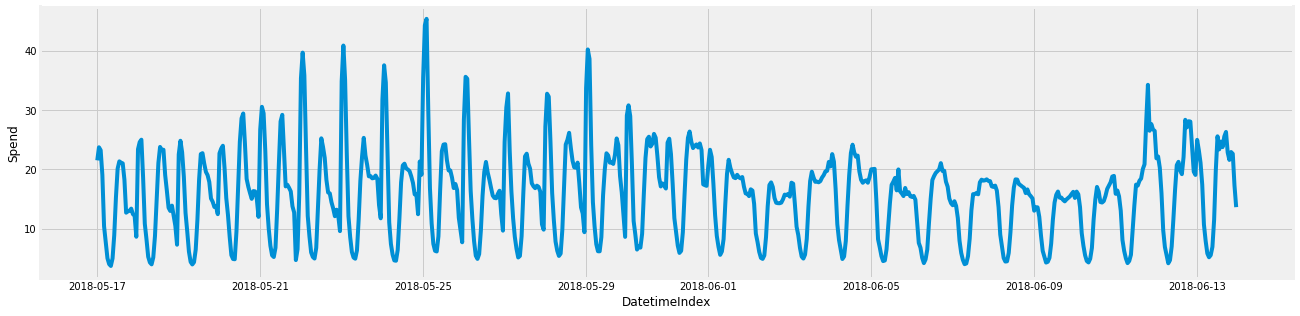

In [6]:
#Plot Data:

rcParams['figure.figsize'] = 20, 5
plt.xlabel('DatetimeIndex')
plt.ylabel('Spend')
plt.plot(df)

#### Based upon the above plot data apppears stationary but we will do some more checks

In [7]:
#Determine rolling statistics:
#Using 24 because we are dealing with hourly data

rolmean = df.rolling(window=24).mean()
rolstd = df.rolling(window=24).std()

print (rolmean, rolstd)

                         spend
new_date                      
2018-05-17 00:00:00        NaN
2018-05-17 01:00:00        NaN
2018-05-17 02:00:00        NaN
2018-05-17 03:00:00        NaN
2018-05-17 04:00:00        NaN
2018-05-17 05:00:00        NaN
2018-05-17 06:00:00        NaN
2018-05-17 07:00:00        NaN
2018-05-17 08:00:00        NaN
2018-05-17 09:00:00        NaN
2018-05-17 10:00:00        NaN
2018-05-17 11:00:00        NaN
2018-05-17 12:00:00        NaN
2018-05-17 13:00:00        NaN
2018-05-17 14:00:00        NaN
2018-05-17 15:00:00        NaN
2018-05-17 16:00:00        NaN
2018-05-17 17:00:00        NaN
2018-05-17 18:00:00        NaN
2018-05-17 19:00:00        NaN
2018-05-17 20:00:00        NaN
2018-05-17 21:00:00        NaN
2018-05-17 22:00:00        NaN
2018-05-17 23:00:00  13.947917
2018-05-18 00:00:00  14.026250
2018-05-18 01:00:00  14.062917
2018-05-18 02:00:00  14.136667
2018-05-18 03:00:00  14.118333
2018-05-18 04:00:00  14.136250
2018-05-18 05:00:00  14.157083
...     

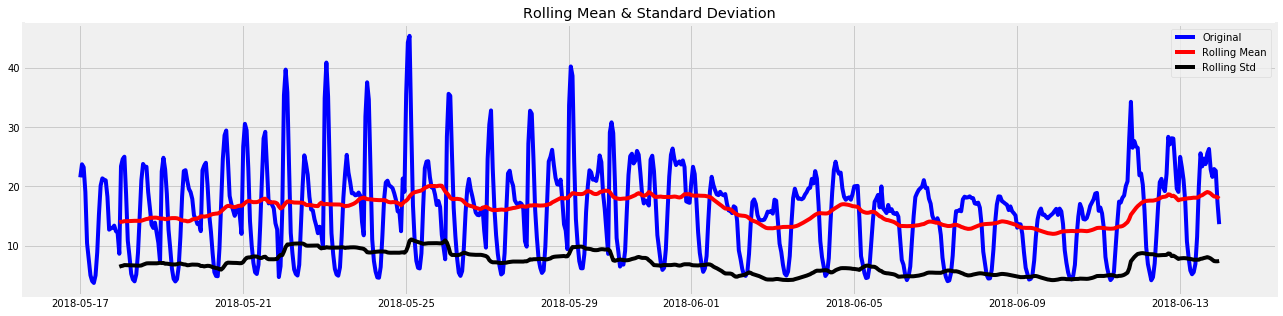

In [8]:
#Plot rolling statistics

orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title("Rolling Mean & Standard Deviation")
plt.show(block=False)

#### In the above plot the mean and the standard deviation appear close to constant (minimal fluctuations) point to the data being stationary

In [9]:
#Perform Dickey-Fuller test:
#Null Hypothesis = Data is not stationary

from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test: ')
dftest = adfuller(df['spend'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test: 
Test Statistic                  -3.824454
p-value                          0.002667
#Lags Used                      20.000000
Number of Observations Used    649.000000
Critical Value (1%)             -3.440466
Critical Value (5%)             -2.866004
Critical Value (10%)            -2.569147
dtype: float64


#### Critical values < Test Statistic & p-value < 0.05
#### We can reject the null hypothesis which says the time series is not stationary

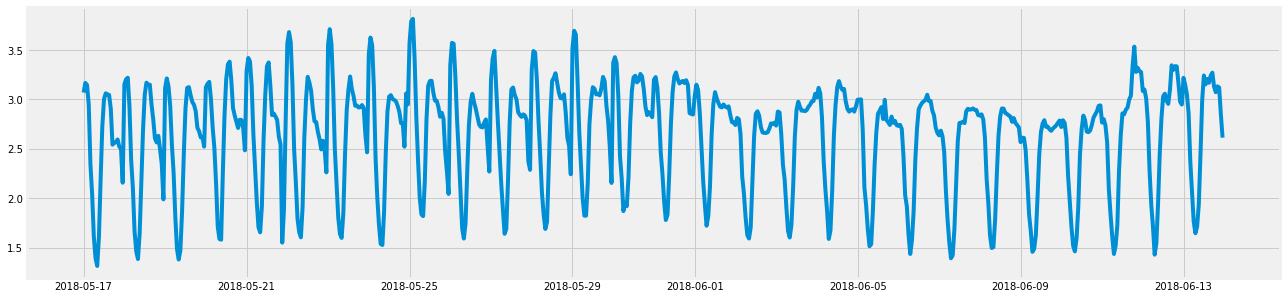

In [10]:
#Look at the log

df_logscale = np.log(df)
plt.plot(df_logscale)

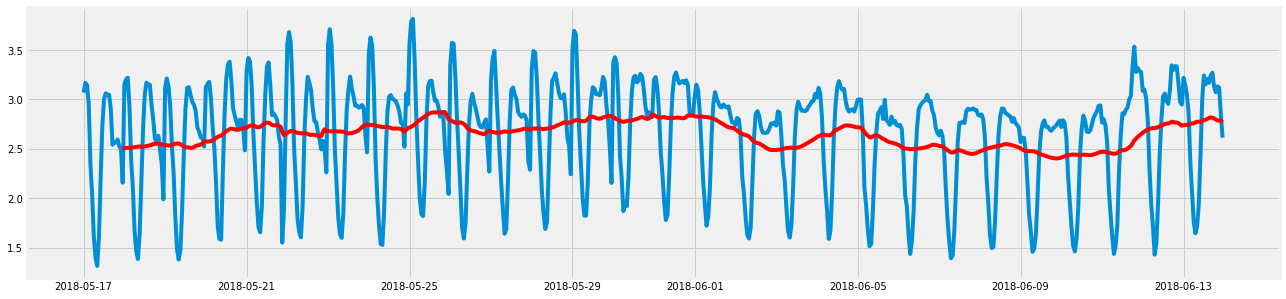

In [11]:
movingAverage = df_logscale.rolling(window=24).mean()
movingSTD = df_logscale.rolling(window=24).std()
plt.plot(df_logscale)
plt.plot(movingAverage, color='red')

In [12]:
df_Minus_MovingAverage = df - rolmean
df_Minus_MovingAverage.head(24)

#Remove Nan Values
df_Minus_MovingAverage.dropna(inplace=True)
df_Minus_MovingAverage.head(20)

,spend
new_date,
2018-05-17 23:00:00,-5.307917
2018-05-18 00:00:00,9.373750
2018-05-18 01:00:00,10.537083
2018-05-18 02:00:00,10.863333
2018-05-18 03:00:00,4.501667
2018-05-18 04:00:00,-3.296250
2018-05-18 05:00:00,-5.957083
2018-05-18 06:00:00,-8.897917
2018-05-18 07:00:00,-9.869583


In [13]:
#Function to run all my tests

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    movingAverage = timeseries.rolling(window=24).mean()
    movingSTD = timeseries.rolling(window=24).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test: ')
    dftest = adfuller(df['spend'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

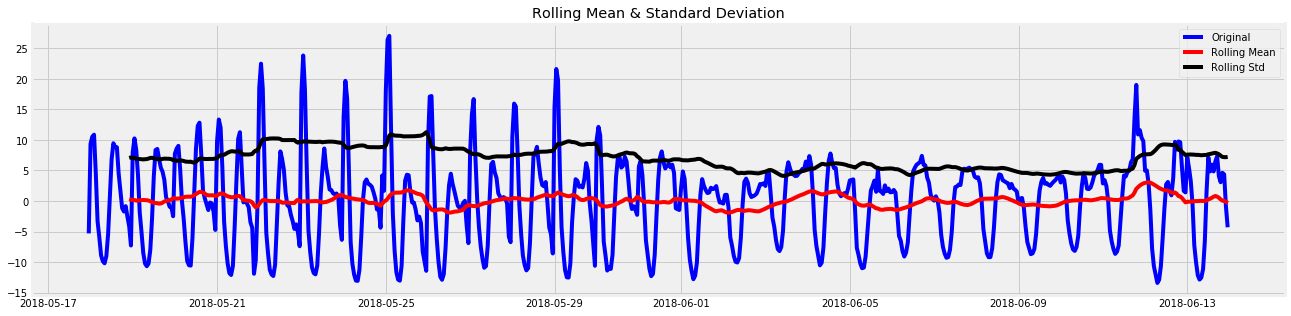

Results of Dickey-Fuller Test: 
Test Statistic                  -3.824454
p-value                          0.002667
#Lags Used                      20.000000
Number of Observations Used    649.000000
Critical Value (1%)             -3.440466
Critical Value (5%)             -2.866004
Critical Value (10%)            -2.569147
dtype: float64


In [14]:
test_stationarity(df_Minus_MovingAverage)

#### Critical values < Test Statistic & p-value < 0.05
#### We can reject the null hypothesis which says the time series is not stationary

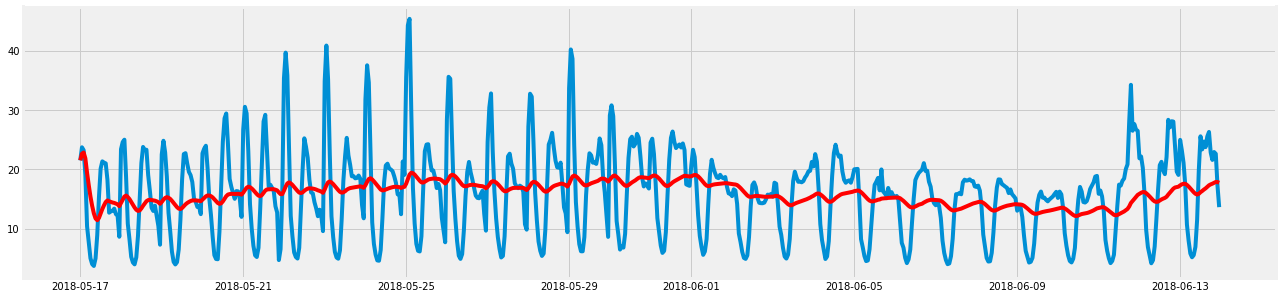

In [15]:
#Check for trend
df_expotentialDecayWeightedAverage = df.ewm(halflife=24, min_periods=0, adjust=True).mean()
plt.plot(df)
plt.plot(df_expotentialDecayWeightedAverage, color='red')

#### Even though I know there is no trend by the previous plots I did the above to be thorough

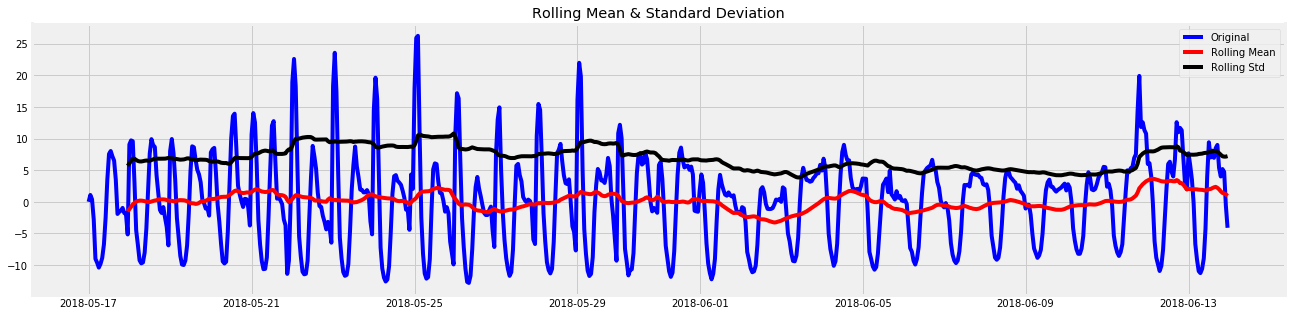

Results of Dickey-Fuller Test: 
Test Statistic                  -3.824454
p-value                          0.002667
#Lags Used                      20.000000
Number of Observations Used    649.000000
Critical Value (1%)             -3.440466
Critical Value (5%)             -2.866004
Critical Value (10%)            -2.569147
dtype: float64


In [16]:
df_Minus_MovingAverage_ExpotentialDecayAverage = df - df_expotentialDecayWeightedAverage
test_stationarity(df_Minus_MovingAverage_ExpotentialDecayAverage)

#### Critical values < Test Statistic & p-value < 0.05
#### We can reject the null hypothesis which says the time series is not stationary

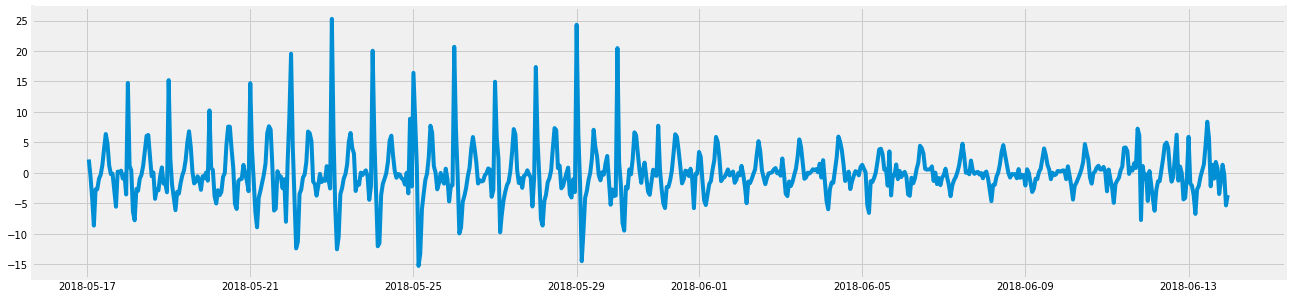

In [17]:
#Shift values to prepare for forecasting
df_DiffShifting = df - df.shift()
plt.plot(df_DiffShifting)

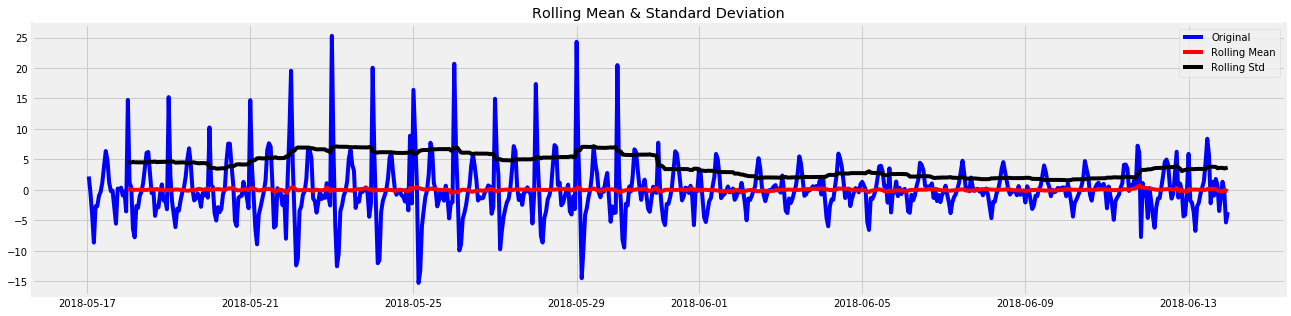

Results of Dickey-Fuller Test: 
Test Statistic                  -3.824454
p-value                          0.002667
#Lags Used                      20.000000
Number of Observations Used    649.000000
Critical Value (1%)             -3.440466
Critical Value (5%)             -2.866004
Critical Value (10%)            -2.569147
dtype: float64


In [18]:
df_DiffShifting.dropna(inplace=True)
test_stationarity(df_DiffShifting)

#### Critical values < Test Statistic & p-value < 0.05
#### We can reject the null hypothesis which says the time series is not stationary

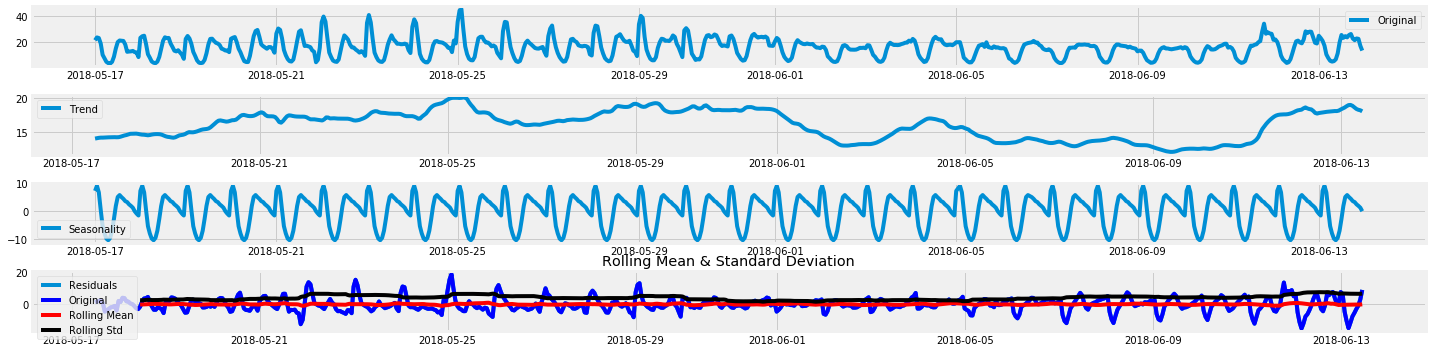

Results of Dickey-Fuller Test: 
Test Statistic                  -3.824454
p-value                          0.002667
#Lags Used                      20.000000
Number of Observations Used    649.000000
Critical Value (1%)             -3.440466
Critical Value (5%)             -2.866004
Critical Value (10%)            -2.569147
dtype: float64


In [19]:
decomposition = seasonal_decompose(df, freq=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout() 

decomposedData = residual
decomposedData.dropna(inplace=True)
test_stationarity(decomposedData)

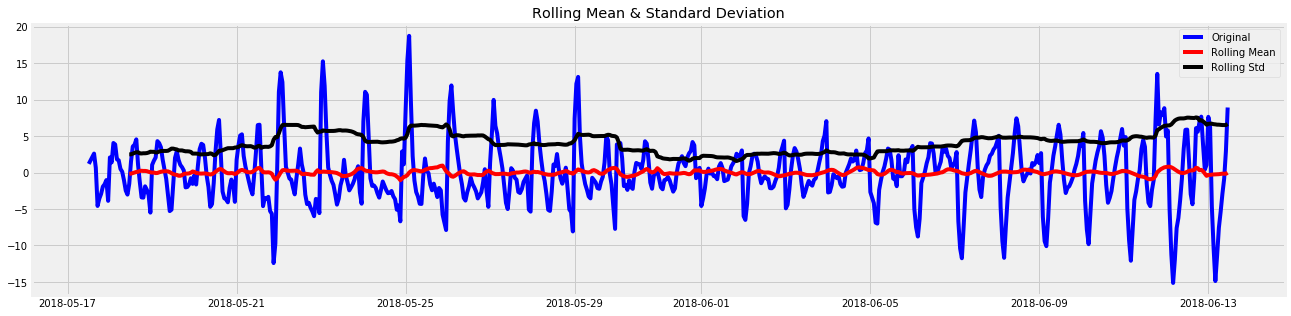

Results of Dickey-Fuller Test: 
Test Statistic                  -3.824454
p-value                          0.002667
#Lags Used                      20.000000
Number of Observations Used    649.000000
Critical Value (1%)             -3.440466
Critical Value (5%)             -2.866004
Critical Value (10%)            -2.569147
dtype: float64


In [20]:
#Plotting residuals to see noise in the data

decomposedData = residual
decomposedData.dropna(inplace=True)
test_stationarity(decomposedData)

#### We can see from the above stats that the noise is also stationary

#### Plotting Correlations

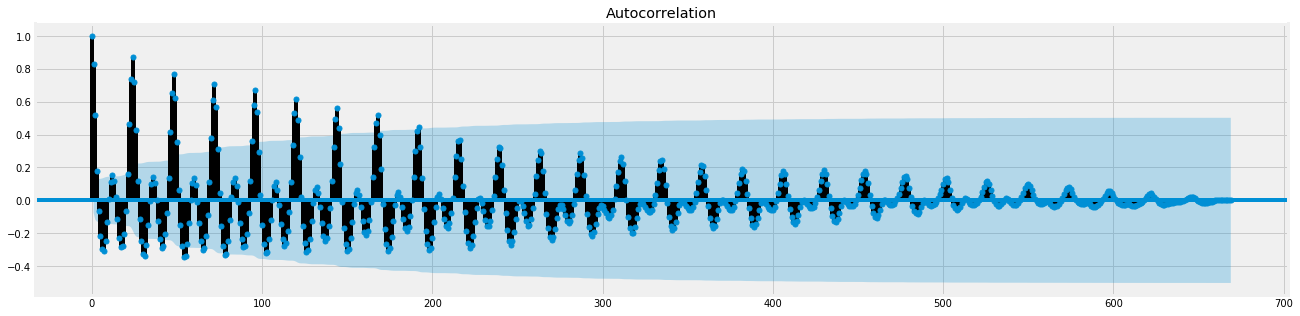

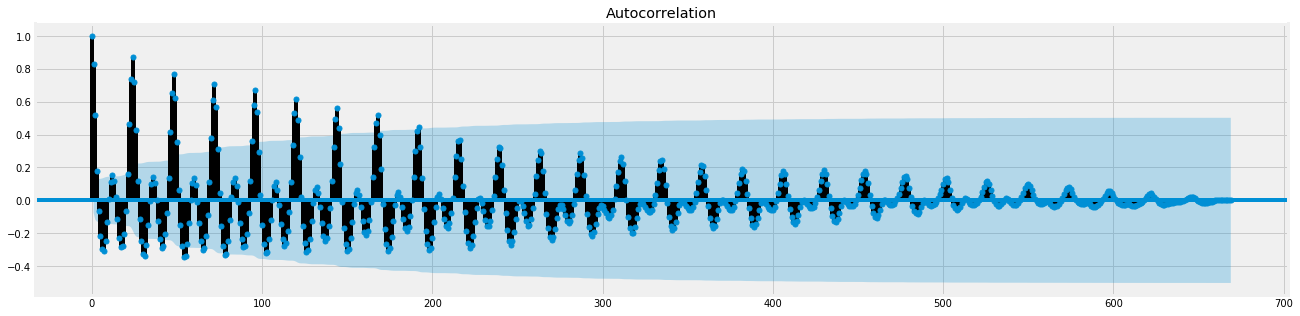

In [21]:
plot_acf(df)

/Users/leon/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


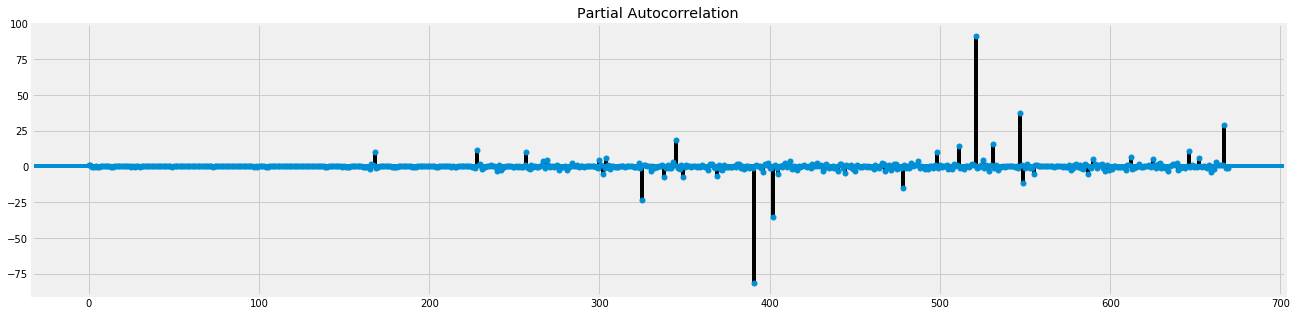

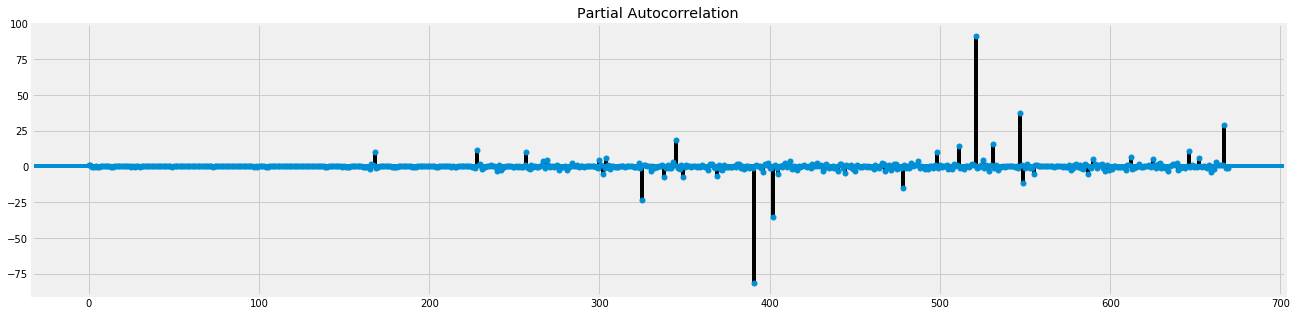

In [23]:
plot_pacf(df)

### Begin Modelling

In [24]:
df.size

670

In [26]:
#Test train / spit (70 / 30)
X = df.values
train = X[0:469] 
test = X[469:]  
predictions = []

In [27]:
train.size

469

In [28]:
test.size

201

In [30]:
model_ar = AR(train)
model_ar_fit = model_ar.fit()

In [31]:
ar_predictions = model_ar_fit.predict(start=469,end=670)

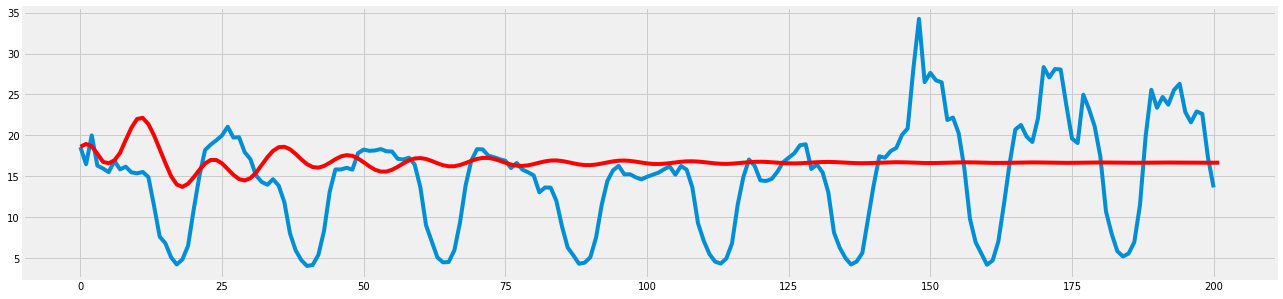

In [33]:
plt.plot(test)
plt.plot(ar_predictions,color='red')

#### This plot shows our predictions with AR are fairly terrible

In [34]:
#p,d,q  p = periods taken for autoregressive model
#d -> Integrated order, difference
# q periods in moving average model
#Choices come a partial grid search that was performed at the end


model_arima = ARIMA(train,order=(17, 0, 14))
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)

2375.2717188212073


/Users/leon/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/leon/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [37]:
arima_predictions= model_arima_fit.forecast(steps=201)[0]
arima_predictions

array([21.65051893, 23.54009158, 24.19987551, 23.16069737, 22.46188992,
       21.05056038, 18.61811389, 17.69604055, 18.37637945, 20.3247434 ,
       19.52793153, 19.9895725 , 19.09393326, 16.76594749, 12.67865395,
        9.72290188,  7.95559991,  7.14943919,  6.83979932,  8.19776285,
       11.69054495, 15.26087682, 18.64706279, 21.04535029, 24.17992841,
       23.94233626, 22.52999548, 20.76700242, 19.74466779, 18.09305608,
       16.75264332, 16.57806881, 17.49161819, 18.4545192 , 18.74861709,
       19.1560771 , 18.61373776, 17.13698421, 13.48468129, 11.38987088,
        9.77825301,  8.83125996,  8.51633019, 10.28974294, 13.25824462,
       16.29709865, 19.25421443, 21.89675751, 23.63040737, 23.19283137,
       21.64168905, 19.44422096, 18.32240496, 16.36805983, 15.30642282,
       15.37381998, 16.52666804, 17.39257967, 18.21502204, 19.08144657,
       18.84732796, 17.17869281, 14.60213137, 12.573397  , 10.89257282,
       10.17670528,  9.88204805, 11.72802102, 14.25493563, 17.03

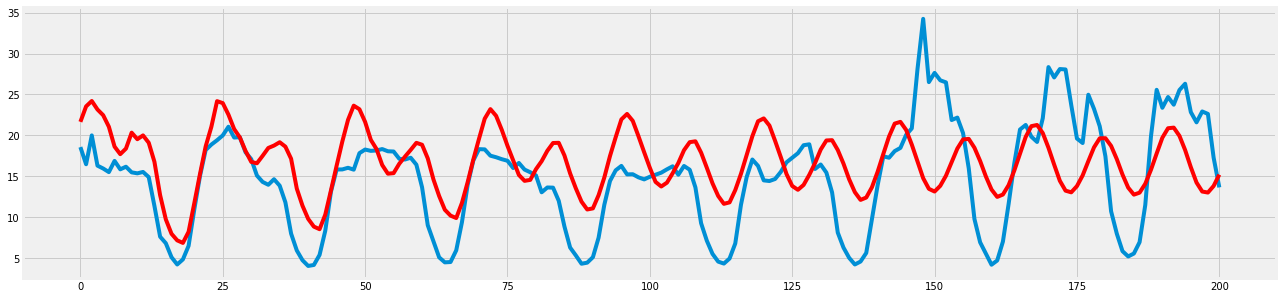

In [39]:
plt.plot(test)
plt.plot(arima_predictions, color='red')

#### This is much better.  It still needs a lot of work.  Next would be feature engineering times to try to find more signal

### Here are the 7 hours

In [52]:
forecast = model_arima_fit.predict(start=0, end=7)
forecast

array([16.60101113, 20.5455737 , 22.73747851, 20.97722498, 15.9681919 ,
        7.54256162,  8.36852145,  7.80845842])

### Unfinished Grid Search 

In [19]:
import itertools
p=d=q=range(0,25)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9),
 (0, 0, 10),
 (0, 0, 11),
 (0, 0, 12),
 (0, 0, 13),
 (0, 0, 14),
 (0, 0, 15),
 (0, 0, 16),
 (0, 0, 17),
 (0, 0, 18),
 (0, 0, 19),
 (0, 0, 20),
 (0, 0, 21),
 (0, 0, 22),
 (0, 0, 23),
 (0, 0, 24),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (0, 1, 10),
 (0, 1, 11),
 (0, 1, 12),
 (0, 1, 13),
 (0, 1, 14),
 (0, 1, 15),
 (0, 1, 16),
 (0, 1, 17),
 (0, 1, 18),
 (0, 1, 19),
 (0, 1, 20),
 (0, 1, 21),
 (0, 1, 22),
 (0, 1, 23),
 (0, 1, 24),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 2, 9),
 (0, 2, 10),
 (0, 2, 11),
 (0, 2, 12),
 (0, 2, 13),
 (0, 2, 14),
 (0, 2, 15),
 (0, 2, 16),
 (0, 2, 17),
 (0, 2, 18),
 (0, 2, 19),
 (0, 2, 20),
 (0, 2, 21),
 (0, 2, 22),
 (0, 2, 23),
 (0, 2, 24),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3,

In [ ]:
import warnings
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model_arima = ARIMA(train,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    

(0, 0, 0) 3255.6182541382914
(0, 0, 1) 2870.201300604372
(0, 0, 23) 2403.850764039134
(0, 1, 0) 2812.798326794961
(0, 1, 1) 2723.2301462787136
(0, 1, 2) 2690.922530822715
(0, 1, 3) 2690.094184014959
(0, 1, 4) 2590.785024230002
(0, 1, 5) 2579.796854101249
(0, 1, 6) 2580.0392453278346
(0, 1, 7) 2579.9071430563326
(0, 1, 8) 2577.4049917741972
(0, 2, 0) 2865.936496565739
(0, 2, 1) 2853.2314112603335
(0, 2, 2) 2725.9038021090137
(0, 2, 3) 2693.0919556719246
(1, 0, 0) 2772.5044848956127
(1, 0, 1) 2658.3489214341903
(1, 0, 2) 2592.0605680965286
(1, 0, 3) 2579.566930163919
(1, 0, 4) 2590.5519610291776
(1, 0, 5) 2573.3001930499468
(1, 0, 6) 2566.928037703041
(1, 0, 7) 2568.2783701720464
(1, 0, 8) 2568.477281284081
(1, 0, 9) 2565.60067254785
(1, 0, 10) 2567.4389909774322
(1, 0, 11) 2568.5854119733112
(1, 0, 12) 2544.352628904539
(1, 0, 13) 2521.009651203942
(1, 0, 14) 2512.4134614364393
(1, 0, 15) 2512.174276439181
(1, 0, 16) 2505.1424506477288
(1, 0, 17) 2481.9935538087902
(1, 0, 18) 2465.39587

In [ ]:
import statsmodels.api as sm
AR1 = sm.tsa.AR(weekly_flu_numbers, freq="H").fit(maxlag=1)
AR2 = sm.tsa.AR(weekly_flu_numbers, freq="H").fit(maxlag=24) 